# Введение в нейронные сети на PyTorch

## Загрузка датасета

In [1]:
import torch

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available else torch.device("cpu") 

In [3]:
device

device(type='cuda', index=0)

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [5]:
data_tfs = tfs.Compose([
                        tfs.ToTensor(),
                        tfs.Normalize((0.5), (0.5))
])

In [6]:
root = "./"
train = MNIST(root, train=True, transform=data_tfs, download=True)
test = MNIST(root, train=False, transform=data_tfs, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
print(f"Data size: \n\t train: {len(train)} \n\t test: {len(test)}")
print(f"Data shape: \n\t features: {train[0][0].shape} \n\t target: {type(test[0][1])}")

Data size: 
	 train: 60000 
	 test: 10000
Data shape: 
	 features: torch.Size([1, 28, 28]) 
	 target: <class 'int'>


In [8]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [9]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

##Определение модели и ее обучение

In [21]:
features = 784
classes = 10

In [22]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[ 0.0194,  0.0126, -0.0126,  ...,  0.0232,  0.0351, -0.0283],
        [ 0.0114, -0.0136,  0.0306,  ...,  0.0020, -0.0180, -0.0144],
        [-0.0082,  0.0009,  0.0229,  ..., -0.0290,  0.0177,  0.0199],
        ...,
        [ 0.0065, -0.0327, -0.0180,  ..., -0.0353,  0.0294, -0.0218],
        [-0.0052,  0.0156,  0.0332,  ...,  0.0308,  0.0186, -0.0225],
        [-0.0008,  0.0050,  0.0043,  ...,  0.0118,  0.0338,  0.0015]],
       requires_grad=True)

In [23]:
epochs = 6
lr = 1e-2
history = []

In [24]:
import numpy as numpy
from torch.nn.functional import cross_entropy
from tqdm.notebook import trange, tqdm

In [25]:
for i in tqdm(range(epochs)):
  for x_batch, y_batch in tqdm(train_loader):
    x_batch = x_batch.reshape(x_batch.shape[0], -1).to(device)

    logits = x_batch @ W.to(device)
    probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdims=True)

    loss = -torch.log(probabilities[range(batch_size), y_batch.to(device)]).mean() 
    history.append(loss.item())

    loss.backward()

    with torch.no_grad():
      W -= lr * W.grad
    W.grad.zero_()
    
  print(f"Epoch {i + 1}, loss: {history[-1]}")


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1, loss: 0.574860692024231


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2, loss: 0.4124239385128021


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3, loss: 0.26202598214149475


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4, loss: 0.32691332697868347


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5, loss: 0.34274566173553467


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6, loss: 0.3575679659843445


In [26]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Batches')

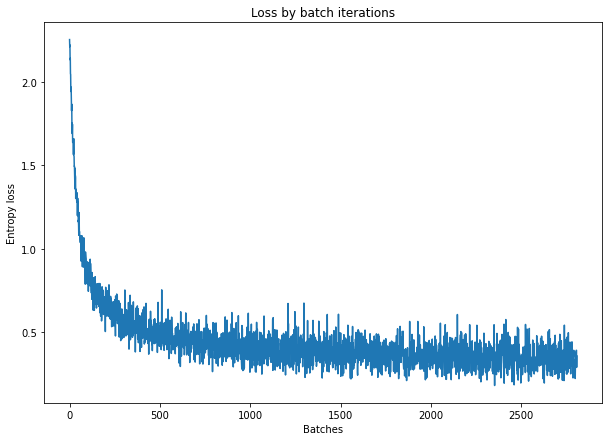

In [27]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title("Loss by batch iterations")
plt.ylabel("Entropy loss")
plt.xlabel("Batches")

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
acc = 0
batches = 0

for x_batch, y_batch in tqdm(test_loader):
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)
  
  preds = torch.argmax(x_batch @ W.to(device), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f"Test accuracy: {acc / batches}")

  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.9106570512820513


### Модель

PyTorch - это гибкий фреймворк для построения любой нейронной сети.

Вот таблица сравнения:

```
| API             | Flexibility | Convenience |,
|-----------------|-------------|-------------|,
| Barebone        | High        | Low         |,
| `nn.Module`     | High        | Medium      |,
| `nn.Sequential` | Low         | High        |
```

#### Sequential

In [30]:
import torch.nn as nn
from torchsummary import summary

In [31]:
model = nn.Sequential(
    nn.Linear(features, 64),
    nn.ReLU(),
    nn.Linear(64, classes)
)

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [33]:
summary(model, (features,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [128, 64]          50,240
              ReLU-2                  [128, 64]               0
            Linear-3                  [128, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 0.13
Params size (MB): 0.19
Estimated Total Size (MB): 0.71
----------------------------------------------------------------


In [34]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [35]:
epochs = 6
history = []

In [36]:
for i in tqdm(range(epochs)):
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)

    loss = criterion(logits, y_batch)
    history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  print(f"Epoch {i + 1}, loss: {history[-1]}")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1, loss: 0.5074561834335327
Epoch 2, loss: 0.1927095353603363
Epoch 3, loss: 0.3081631660461426
Epoch 4, loss: 0.18165814876556396
Epoch 5, loss: 0.1501399576663971
Epoch 6, loss: 0.03377541899681091


Text(0.5, 0, 'Batches')

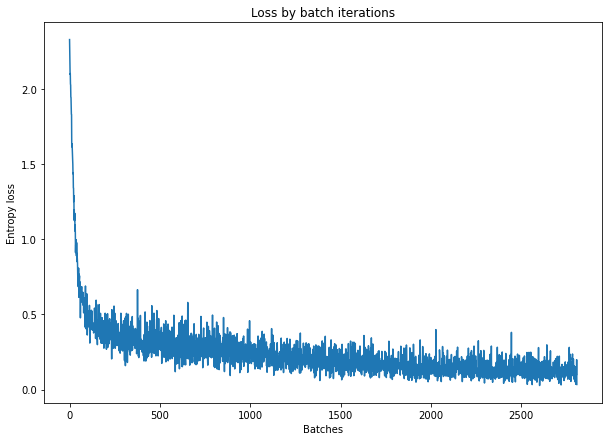

In [37]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title("Loss by batch iterations")
plt.ylabel("Entropy loss")
plt.xlabel("Batches")

In [38]:
from sklearn.metrics import accuracy_score

acc = 0
batches = 0

for x_batch, y_batch in tqdm(test_loader):

  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model(x_batch), dim=1)
  acc += accuracy_score(y_batch.cpu().numpy(), preds.cpu().numpy())

print(f"Test accuracy: {acc / batches}")


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.9632411858974359
